In [ ]:
#!pip install opencv-python-headless

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

# Experiment 1

### Two point crossover with SSIM

* Run 1

In [1]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def two_point_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    point1 = random.randint(0, len(parent1.triangles) - 1)
    point2 = random.randint(point1, len(parent1.triangles))

    child1.triangles[point1:point2], child2.triangles[point1:point2] = parent2.triangles[point1:point2], parent1.triangles[point1:point2]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = two_point_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

C:\Users\barbara\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Run 1
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 77  77  77]
 [167 167 167]
 [119  66   0]
 [212 212 212]
 [ 38  33  27]
 [122 122 122]
 [223 123   0]]
Generation 1, Best Fitness: 0.33006428831085644
Generation 2, Best Fitness: 0.3270422097125093
Generation 3, Best Fitness: 0.3251590836029328
Generation 4, Best Fitness: 0.3220135058528587
Generation 5, Best Fitness: 0.31693612800193016
Generation 6, Best Fitness: 0.3147518057446109
Generation 7, Best Fitness: 0.3147381450529505
Generation 8, Best Fitness: 0.3141358676186684
Generation 9, Best Fitness: 0.31384025096597645
Generation 10, Best Fitness: 0.31271929481225624
Generation 11, Best Fitness: 0.31242429356583723
Generation 12, Best Fitness: 0.3118229161830536
Generation 13, Best Fitness: 0.3107426406195456
Generation 14, Best Fitness: 0.30953028461319554
Generation 15, Best Fitness: 0.30951310054462167
Generation 16, Best Fitness: 0.30935571109614535
Generation 17, Best Fitness: 0.3080497597048929
Generatio

Generation 165, Best Fitness: 0.21911762912910637
Generation 166, Best Fitness: 0.21866542335122952
Generation 167, Best Fitness: 0.2186110414196195
Generation 168, Best Fitness: 0.2173367222322491
Generation 169, Best Fitness: 0.2173367222322491
Generation 170, Best Fitness: 0.2173367222322491
Generation 171, Best Fitness: 0.21694037550995127
Generation 172, Best Fitness: 0.21694037550995127
Generation 173, Best Fitness: 0.2165975608921673
Generation 174, Best Fitness: 0.2163014471366167
Generation 175, Best Fitness: 0.21599786465505888
Generation 176, Best Fitness: 0.21599786465505888
Generation 177, Best Fitness: 0.21529492208443857
Generation 178, Best Fitness: 0.2152261460109014
Generation 179, Best Fitness: 0.21341612802293897
Generation 180, Best Fitness: 0.21287315677158436
Generation 181, Best Fitness: 0.21099598904445938
Generation 182, Best Fitness: 0.21018912647043486
Generation 183, Best Fitness: 0.206298725597149
Generation 184, Best Fitness: 0.206298725597149
Generation 

Generation 330, Best Fitness: 0.1409083114856532
Generation 331, Best Fitness: 0.14088457249271158
Generation 332, Best Fitness: 0.14000721348943557
Generation 333, Best Fitness: 0.14000474737373492
Generation 334, Best Fitness: 0.1399832789414852
Generation 335, Best Fitness: 0.1399832789414852
Generation 336, Best Fitness: 0.1399832789414852
Generation 337, Best Fitness: 0.13908340131884944
Generation 338, Best Fitness: 0.13908340131884944
Generation 339, Best Fitness: 0.1390536497917384
Generation 340, Best Fitness: 0.1390536497917384
Generation 341, Best Fitness: 0.13812587490708583
Generation 342, Best Fitness: 0.13809425188193925
Generation 343, Best Fitness: 0.13757847524891853
Generation 344, Best Fitness: 0.13753821566975344
Generation 345, Best Fitness: 0.13659731982457934
Generation 346, Best Fitness: 0.13659731982457934
Generation 347, Best Fitness: 0.13604057393707447
Generation 348, Best Fitness: 0.13604057393707447
Generation 349, Best Fitness: 0.13604057393707447
Genera

Generation 495, Best Fitness: 0.11463304273169095
Generation 496, Best Fitness: 0.11463304273169095
Generation 497, Best Fitness: 0.11463304273169095
Generation 498, Best Fitness: 0.11461644373030344
Generation 499, Best Fitness: 0.11461644373030344
Generation 500, Best Fitness: 0.11459412442642758


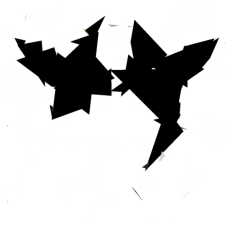

In [2]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

In [1]:
for run in range(1):
    print(f"Run {run + 2}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 2
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [113 113 113]
 [210 210 210]
 [119  66   0]
 [160 160 160]
 [ 71  71  71]
 [223 123   0]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.32835717822887955
Generation 2, Best Fitness: 0.32818414708815435
Generation 3, Best Fitness: 0.3248881389190159
Generation 4, Best Fitness: 0.32167166896595334
Generation 5, Best Fitness: 0.32154022216215083
Generation 6, Best Fitness: 0.3200284952167153
Generation 7, Best Fitness: 0.3188610381038478
Generation 8, Best Fitness: 0.3188610381038478
Generation 9, Best Fitness: 0.3183067569884235
Generation 10, Best Fitness: 0.31723054597613054
Generation 11, Best Fitness: 0.31686392602017077
Generation 12, Best Fitness: 0.3149930979400971
Generation 13, Best Fitness: 0.31458012220694187
Generation 14, Best Fitness: 0.31458012220694187
Generation 15, Best Fitness: 0.31142796461685984
Generation 16, Best Fitness: 0.31142796461685984
Generation 17, Best Fitness: 0.31103688779382566
Genera

Generation 165, Best Fitness: 0.2196218384132118
Generation 166, Best Fitness: 0.21868304965336316
Generation 167, Best Fitness: 0.21868304965336316
Generation 168, Best Fitness: 0.21628894082539463
Generation 169, Best Fitness: 0.21477204814521478
Generation 170, Best Fitness: 0.21477204814521478
Generation 171, Best Fitness: 0.2118555891146996
Generation 172, Best Fitness: 0.21116989512710194
Generation 173, Best Fitness: 0.2110980482431679
Generation 174, Best Fitness: 0.21014698644438945
Generation 175, Best Fitness: 0.21014698644438945
Generation 176, Best Fitness: 0.20938888958442836
Generation 177, Best Fitness: 0.20938888958442836
Generation 178, Best Fitness: 0.20929229934997173
Generation 179, Best Fitness: 0.2092901086682185
Generation 180, Best Fitness: 0.2092620627712789
Generation 181, Best Fitness: 0.20878603542269003
Generation 182, Best Fitness: 0.20760597746542697
Generation 183, Best Fitness: 0.20755498762772762
Generation 184, Best Fitness: 0.2069911043234709
Genera

Generation 330, Best Fitness: 0.14460918586427984
Generation 331, Best Fitness: 0.1445536393674559
Generation 332, Best Fitness: 0.14433287618322832
Generation 333, Best Fitness: 0.14433287618322832
Generation 334, Best Fitness: 0.144172655576991
Generation 335, Best Fitness: 0.144172655576991
Generation 336, Best Fitness: 0.144172655576991
Generation 337, Best Fitness: 0.14411817399580074
Generation 338, Best Fitness: 0.14392420491356317
Generation 339, Best Fitness: 0.1439192952873274
Generation 340, Best Fitness: 0.14391892212438684
Generation 341, Best Fitness: 0.1430232832609969
Generation 342, Best Fitness: 0.1430232832609969
Generation 343, Best Fitness: 0.1430151914049822
Generation 344, Best Fitness: 0.1430151914049822
Generation 345, Best Fitness: 0.14298922213650167
Generation 346, Best Fitness: 0.14282171024365786
Generation 347, Best Fitness: 0.1421064686606126
Generation 348, Best Fitness: 0.14124463148078548
Generation 349, Best Fitness: 0.14124463148078548
Generation 35

Generation 495, Best Fitness: 0.11627664540138949
Generation 496, Best Fitness: 0.1157463576348865
Generation 497, Best Fitness: 0.1157463576348865
Generation 498, Best Fitness: 0.1157463576348865
Generation 499, Best Fitness: 0.11568357004072427
Generation 500, Best Fitness: 0.11547587744919108


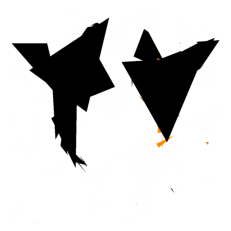

In [3]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [4]:
for run in range(1):
    print(f"Run {run + 3}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 3
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [113 113 113]
 [210 210 210]
 [ 71  71  71]
 [160 160 160]
 [119  66   0]
 [223 123   0]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.3300745488982767
Generation 2, Best Fitness: 0.32616931628996226
Generation 3, Best Fitness: 0.3208590385569622
Generation 4, Best Fitness: 0.3208590385569622
Generation 5, Best Fitness: 0.320068250303434
Generation 6, Best Fitness: 0.3156366360616719
Generation 7, Best Fitness: 0.31462627811518695
Generation 8, Best Fitness: 0.3135321301970554
Generation 9, Best Fitness: 0.3116106714553326
Generation 10, Best Fitness: 0.3104335064163021
Generation 11, Best Fitness: 0.3101627702448869
Generation 12, Best Fitness: 0.31006675027863007
Generation 13, Best Fitness: 0.31006675027863007
Generation 14, Best Fitness: 0.3096222027740594
Generation 15, Best Fitness: 0.30955258449608536
Generation 16, Best Fitness: 0.30889839785943096
Generation 17, Best Fitness: 0.3078956051801497
Generation 1

Generation 166, Best Fitness: 0.22786043081571694
Generation 167, Best Fitness: 0.22663270917088807
Generation 168, Best Fitness: 0.22663270917088807
Generation 169, Best Fitness: 0.22663270917088807
Generation 170, Best Fitness: 0.22616859346573615
Generation 171, Best Fitness: 0.2259702954536439
Generation 172, Best Fitness: 0.22510069135351296
Generation 173, Best Fitness: 0.2248892609520916
Generation 174, Best Fitness: 0.2248471654526072
Generation 175, Best Fitness: 0.22433064576968464
Generation 176, Best Fitness: 0.22427018572657897
Generation 177, Best Fitness: 0.2242372993619306
Generation 178, Best Fitness: 0.2235525035779925
Generation 179, Best Fitness: 0.22325045912811625
Generation 180, Best Fitness: 0.22271032896911735
Generation 181, Best Fitness: 0.22221648091242674
Generation 182, Best Fitness: 0.2222164647436975
Generation 183, Best Fitness: 0.22202717385598314
Generation 184, Best Fitness: 0.22185520444133444
Generation 185, Best Fitness: 0.22136082561920312
Genera

Generation 331, Best Fitness: 0.15687869090652473
Generation 332, Best Fitness: 0.15574973000549241
Generation 333, Best Fitness: 0.15574872300085485
Generation 334, Best Fitness: 0.15566056036849862
Generation 335, Best Fitness: 0.15566056036849862
Generation 336, Best Fitness: 0.15419673703389836
Generation 337, Best Fitness: 0.15419673703389836
Generation 338, Best Fitness: 0.15359627013784283
Generation 339, Best Fitness: 0.15359627013784283
Generation 340, Best Fitness: 0.15355891509199637
Generation 341, Best Fitness: 0.15339202458656587
Generation 342, Best Fitness: 0.15339202458656587
Generation 343, Best Fitness: 0.15335081759541325
Generation 344, Best Fitness: 0.1531854683614704
Generation 345, Best Fitness: 0.15303977143959102
Generation 346, Best Fitness: 0.15235121322184564
Generation 347, Best Fitness: 0.15235121322184564
Generation 348, Best Fitness: 0.1518673861944495
Generation 349, Best Fitness: 0.15153660885725329
Generation 350, Best Fitness: 0.15153660885725329
Ge

Generation 496, Best Fitness: 0.13153928252019786
Generation 497, Best Fitness: 0.1315347513141194
Generation 498, Best Fitness: 0.13147451785331543
Generation 499, Best Fitness: 0.1314743990102406
Generation 500, Best Fitness: 0.13109085767674045


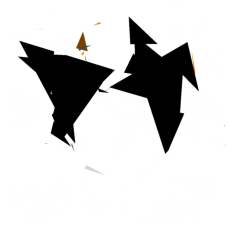

In [5]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

In [2]:
for run in range(1):
    print(f"Run {run + 4}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 4
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [164 164 164]
 [ 73  73  73]
 [119  66   0]
 [212 212 212]
 [ 37  31  24]
 [223 123   0]
 [117 117 117]]
Generation 1, Best Fitness: 0.32633387845538575
Generation 2, Best Fitness: 0.32456445982134263
Generation 3, Best Fitness: 0.32102563486543056
Generation 4, Best Fitness: 0.32102563486543056
Generation 5, Best Fitness: 0.31865729021270517
Generation 6, Best Fitness: 0.3182920813725876
Generation 7, Best Fitness: 0.3182920813725876
Generation 8, Best Fitness: 0.3150577286297829
Generation 9, Best Fitness: 0.3143724817349054
Generation 10, Best Fitness: 0.31401234480563345
Generation 11, Best Fitness: 0.3130204145297599
Generation 12, Best Fitness: 0.3114713883076514
Generation 13, Best Fitness: 0.3114713883076514
Generation 14, Best Fitness: 0.310961360279546
Generation 15, Best Fitness: 0.3100153421843935
Generation 16, Best Fitness: 0.3100153421843935
Generation 17, Best Fitness: 0.3082698210653977
Generation 1

Generation 166, Best Fitness: 0.22616704149054256
Generation 167, Best Fitness: 0.22580368128118256
Generation 168, Best Fitness: 0.22501524531227823
Generation 169, Best Fitness: 0.2248678094777662
Generation 170, Best Fitness: 0.22389396371020742
Generation 171, Best Fitness: 0.22249051309264156
Generation 172, Best Fitness: 0.221681365634806
Generation 173, Best Fitness: 0.22097774143441418
Generation 174, Best Fitness: 0.2206325285073859
Generation 175, Best Fitness: 0.22016094894385907
Generation 176, Best Fitness: 0.22016079140378864
Generation 177, Best Fitness: 0.2198755261292511
Generation 178, Best Fitness: 0.21966461714559593
Generation 179, Best Fitness: 0.21927735819533978
Generation 180, Best Fitness: 0.2189187696865067
Generation 181, Best Fitness: 0.21887511489777356
Generation 182, Best Fitness: 0.21801475321151176
Generation 183, Best Fitness: 0.21755508139851487
Generation 184, Best Fitness: 0.21728421595974223
Generation 185, Best Fitness: 0.2163584088491045
Generat

Generation 331, Best Fitness: 0.13607631385571395
Generation 332, Best Fitness: 0.13607631385571395
Generation 333, Best Fitness: 0.13531040495157542
Generation 334, Best Fitness: 0.13391582601291263
Generation 335, Best Fitness: 0.13389749458515332
Generation 336, Best Fitness: 0.13380467787726547
Generation 337, Best Fitness: 0.1336797912613582
Generation 338, Best Fitness: 0.1335455450701497
Generation 339, Best Fitness: 0.1335455450701497
Generation 340, Best Fitness: 0.13354273031528008
Generation 341, Best Fitness: 0.133535368048472
Generation 342, Best Fitness: 0.13291900791162792
Generation 343, Best Fitness: 0.13291900791162792
Generation 344, Best Fitness: 0.1326708082883249
Generation 345, Best Fitness: 0.1326708082883249
Generation 346, Best Fitness: 0.1326679184129208
Generation 347, Best Fitness: 0.13251240904303108
Generation 348, Best Fitness: 0.13234800169025196
Generation 349, Best Fitness: 0.13234800169025196
Generation 350, Best Fitness: 0.13228132696486838
Generati

Generation 496, Best Fitness: 0.10964084342544833
Generation 497, Best Fitness: 0.10958618834219713
Generation 498, Best Fitness: 0.10958618834219713
Generation 499, Best Fitness: 0.10937797903241375
Generation 500, Best Fitness: 0.10917202169277707


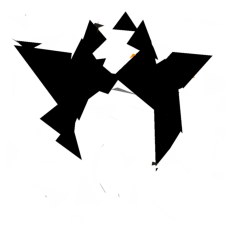

In [4]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5 

In [5]:
for run in range(1):
    print(f"Run {run + 5}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 5
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [108 108 108]
 [123  68   0]
 [148 148 148]
 [188 188 188]
 [ 36  30  24]
 [226 226 226]
 [ 70  70  70]]
Generation 1, Best Fitness: 0.32982949472616174
Generation 2, Best Fitness: 0.32493295430126556
Generation 3, Best Fitness: 0.3226432969520039
Generation 4, Best Fitness: 0.3206663166673107
Generation 5, Best Fitness: 0.32019736465052706
Generation 6, Best Fitness: 0.3196430509681274
Generation 7, Best Fitness: 0.3179985744443343
Generation 8, Best Fitness: 0.31741594506998316
Generation 9, Best Fitness: 0.3153328984269239
Generation 10, Best Fitness: 0.31527944103728767
Generation 11, Best Fitness: 0.31445756627673116
Generation 12, Best Fitness: 0.3132798226494714
Generation 13, Best Fitness: 0.31308616205296746
Generation 14, Best Fitness: 0.3123569493069981
Generation 15, Best Fitness: 0.31091108305830784
Generation 16, Best Fitness: 0.31091108305830784
Generation 17, Best Fitness: 0.3108215279092391
Generati

Generation 166, Best Fitness: 0.23955057889622433
Generation 167, Best Fitness: 0.23888412085242183
Generation 168, Best Fitness: 0.2371291212871548
Generation 169, Best Fitness: 0.2369969925663462
Generation 170, Best Fitness: 0.23583462594689053
Generation 171, Best Fitness: 0.23583444859719738
Generation 172, Best Fitness: 0.23534143555568554
Generation 173, Best Fitness: 0.2353325064617704
Generation 174, Best Fitness: 0.23515274049036494
Generation 175, Best Fitness: 0.2346441350098598
Generation 176, Best Fitness: 0.23338075410251513
Generation 177, Best Fitness: 0.23338075410251513
Generation 178, Best Fitness: 0.23332080829599733
Generation 179, Best Fitness: 0.2329605111921288
Generation 180, Best Fitness: 0.2327890214787156
Generation 181, Best Fitness: 0.23059595810757416
Generation 182, Best Fitness: 0.23044738106441842
Generation 183, Best Fitness: 0.22906112707156068
Generation 184, Best Fitness: 0.22837639361408646
Generation 185, Best Fitness: 0.22837639361408646
Genera

Generation 331, Best Fitness: 0.1392458348170993
Generation 332, Best Fitness: 0.13898058018304926
Generation 333, Best Fitness: 0.13888715406715757
Generation 334, Best Fitness: 0.13878336762499988
Generation 335, Best Fitness: 0.13863987546629875
Generation 336, Best Fitness: 0.13792675690214762
Generation 337, Best Fitness: 0.137595018297061
Generation 338, Best Fitness: 0.137595018297061
Generation 339, Best Fitness: 0.1375672998200228
Generation 340, Best Fitness: 0.1374657642866548
Generation 341, Best Fitness: 0.13675596806124235
Generation 342, Best Fitness: 0.13675596806124235
Generation 343, Best Fitness: 0.13649187523462591
Generation 344, Best Fitness: 0.13558004448140937
Generation 345, Best Fitness: 0.13558004448140937
Generation 346, Best Fitness: 0.13519917222335343
Generation 347, Best Fitness: 0.13519917222335343
Generation 348, Best Fitness: 0.1351215728941847
Generation 349, Best Fitness: 0.13469440042269765
Generation 350, Best Fitness: 0.13429406126171983
Generati

Generation 496, Best Fitness: 0.10302289717655877
Generation 497, Best Fitness: 0.10302289717655877
Generation 498, Best Fitness: 0.10301969237906872
Generation 499, Best Fitness: 0.10295245252764007
Generation 500, Best Fitness: 0.10199906898842859


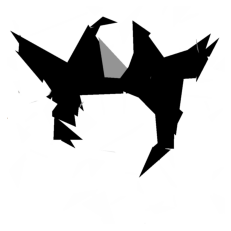

In [6]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

## Plotting mean fitness per generation 

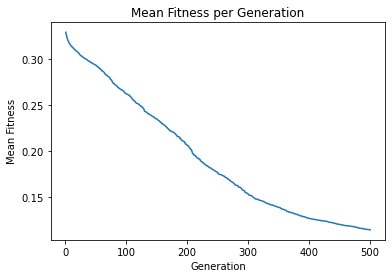

In [13]:
fitness_file = "fitness_values_2PC.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()


### Two Point Crossover with euclidean distance 

* Run 1

In [1]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGB", (self._img_width, self._img_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image)
    rendered_image = np.array(painting.draw())
    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((target_array - rendered_image) ** 2))
    return distance

def two_point_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    point1 = random.randint(0, len(parent1.triangles) - 1)
    point2 = random.randint(point1, len(parent1.triangles))

    child1.triangles[point1:point2], child2.triangles[point1:point2] = parent2.triangles[point1:point2], parent1.triangles[point1:point2]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = two_point_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_euclidean.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [133 133 133]
 [119  66   0]
 [180 180 180]
 [ 41  36  30]
 [223 223 223]
 [223 123   0]
 [ 83  83  83]]
Generation 1, Best Fitness: 4729.403556475171
Generation 2, Best Fitness: 4690.216306312535
Generation 3, Best Fitness: 4581.120605266794
Generation 4, Best Fitness: 4549.39655339035
Generation 5, Best Fitness: 4478.3121820614515
Generation 6, Best Fitness: 4402.177075039122
Generation 7, Best Fitness: 4370.078717826488
Generation 8, Best Fitness: 4265.605701421546
Generation 9, Best Fitness: 4198.2542800549845
Generation 10, Best Fitness: 4130.697156655278
Generation 11, Best Fitness: 4112.270540711056
Generation 12, Best Fitness: 4034.227187454866
Generation 13, Best Fitness: 4034.227187454866
Generation 14, Best Fitness: 3973.394896055513
Generation 15, Best Fitness: 3973.394896055513
Generation 16, Best Fitness: 3958.822299623968
Generation 17, Best Fitness: 3895.7734790411005
Generation 18, Best Fitness: 389

Generation 169, Best Fitness: 2712.600044238
Generation 170, Best Fitness: 2711.4743222092293
Generation 171, Best Fitness: 2707.0391574559835
Generation 172, Best Fitness: 2702.429647557916
Generation 173, Best Fitness: 2702.1887424826564
Generation 174, Best Fitness: 2701.2935790098786
Generation 175, Best Fitness: 2698.789914017021
Generation 176, Best Fitness: 2661.346087978788
Generation 177, Best Fitness: 2661.346087978788
Generation 178, Best Fitness: 2642.3054327613227
Generation 179, Best Fitness: 2639.2407999271304
Generation 180, Best Fitness: 2638.6576132571654
Generation 181, Best Fitness: 2636.8682181709423
Generation 182, Best Fitness: 2635.5642659589994
Generation 183, Best Fitness: 2626.1816388056636
Generation 184, Best Fitness: 2625.3578803660275
Generation 185, Best Fitness: 2625.3578803660275
Generation 186, Best Fitness: 2608.703509408457
Generation 187, Best Fitness: 2605.898693349379
Generation 188, Best Fitness: 2604.4264243783123
Generation 189, Best Fitness: 

Generation 339, Best Fitness: 2063.740536017064
Generation 340, Best Fitness: 2063.2057580377195
Generation 341, Best Fitness: 2061.572700634154
Generation 342, Best Fitness: 2060.939834153341
Generation 343, Best Fitness: 2060.939834153341
Generation 344, Best Fitness: 2059.4552677832066
Generation 345, Best Fitness: 2055.319926434812
Generation 346, Best Fitness: 2055.319926434812
Generation 347, Best Fitness: 2055.020681161141
Generation 348, Best Fitness: 2053.507974174924
Generation 349, Best Fitness: 2053.507974174924
Generation 350, Best Fitness: 2051.3415122792208
Generation 351, Best Fitness: 2026.7325921295094
Generation 352, Best Fitness: 2023.6017394734567
Generation 353, Best Fitness: 2018.9056441547732
Generation 354, Best Fitness: 2017.0904788828884
Generation 355, Best Fitness: 2017.0904788828884
Generation 356, Best Fitness: 2016.5244853460124
Generation 357, Best Fitness: 2014.2589207944445
Generation 358, Best Fitness: 2014.1137008619946
Generation 359, Best Fitness:

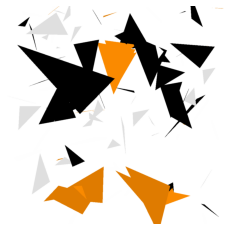

In [2]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

In [3]:
for run in range(1):
    print(f"Run {run + 2}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 2
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 69  69  69]
 [146 146 146]
 [123  68   0]
 [107 107 107]
 [224 224 224]
 [186 186 186]
 [ 36  30  23]]
Generation 1, Best Fitness: 4747.922071812047
Generation 2, Best Fitness: 4701.932049700421
Generation 3, Best Fitness: 4701.932049700421
Generation 4, Best Fitness: 4570.800805110632
Generation 5, Best Fitness: 4570.800805110632
Generation 6, Best Fitness: 4570.800805110632
Generation 7, Best Fitness: 4513.546166818282
Generation 8, Best Fitness: 4447.692098156076
Generation 9, Best Fitness: 4447.692098156076
Generation 10, Best Fitness: 4433.481025108826
Generation 11, Best Fitness: 4412.846133732741
Generation 12, Best Fitness: 4391.375410961809
Generation 13, Best Fitness: 4376.705953111312
Generation 14, Best Fitness: 4333.603581316593
Generation 15, Best Fitness: 4292.1706629629725
Generation 16, Best Fitness: 4281.447418805935
Generation 17, Best Fitness: 4272.402485721587
Generation 18, Best Fitness: 4231

Generation 169, Best Fitness: 3204.159640217697
Generation 170, Best Fitness: 3204.15636322574
Generation 171, Best Fitness: 3199.3477460257427
Generation 172, Best Fitness: 3199.3477460257427
Generation 173, Best Fitness: 3198.5473265218384
Generation 174, Best Fitness: 3182.335620263834
Generation 175, Best Fitness: 3181.0669593707075
Generation 176, Best Fitness: 3167.0481524599527
Generation 177, Best Fitness: 3166.505802931679
Generation 178, Best Fitness: 3164.910425272728
Generation 179, Best Fitness: 3143.416930666373
Generation 180, Best Fitness: 3134.395635525292
Generation 181, Best Fitness: 3131.453975392262
Generation 182, Best Fitness: 3120.147752911711
Generation 183, Best Fitness: 3107.87708894673
Generation 184, Best Fitness: 2925.5814806632884
Generation 185, Best Fitness: 2925.1738409879163
Generation 186, Best Fitness: 2907.221697772635
Generation 187, Best Fitness: 2907.221697772635
Generation 188, Best Fitness: 2906.061079881151
Generation 189, Best Fitness: 2895.

Generation 338, Best Fitness: 2179.610515665586
Generation 339, Best Fitness: 2179.0534642362495
Generation 340, Best Fitness: 2177.7499856503273
Generation 341, Best Fitness: 2177.7499856503273
Generation 342, Best Fitness: 2176.1957632529293
Generation 343, Best Fitness: 2175.547057638607
Generation 344, Best Fitness: 2175.547057638607
Generation 345, Best Fitness: 2175.547057638607
Generation 346, Best Fitness: 2174.691932205571
Generation 347, Best Fitness: 2174.691932205571
Generation 348, Best Fitness: 2174.501552080384
Generation 349, Best Fitness: 2153.4741698009752
Generation 350, Best Fitness: 2153.288879830108
Generation 351, Best Fitness: 2136.484495614232
Generation 352, Best Fitness: 2136.484495614232
Generation 353, Best Fitness: 2136.462028681998
Generation 354, Best Fitness: 2136.0231740315926
Generation 355, Best Fitness: 2135.8138963870424
Generation 356, Best Fitness: 2135.7556039959254
Generation 357, Best Fitness: 2128.443327880731
Generation 358, Best Fitness: 21

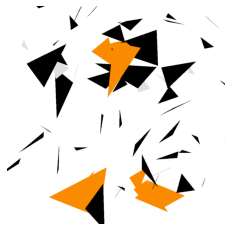

In [4]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [5]:
for run in range(1):
    print(f"Run {run + 3}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 3
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [113 113 113]
 [160 160 160]
 [ 71  71  71]
 [119  66   0]
 [210 210 210]
 [ 36  30  24]
 [223 123   0]]
Generation 1, Best Fitness: 4738.109960733288
Generation 2, Best Fitness: 4614.361385934136
Generation 3, Best Fitness: 4609.593474483406
Generation 4, Best Fitness: 4588.03520038807
Generation 5, Best Fitness: 4577.284129262679
Generation 6, Best Fitness: 4539.976872187787
Generation 7, Best Fitness: 4455.713635322629
Generation 8, Best Fitness: 4359.63381489776
Generation 9, Best Fitness: 4359.63381489776
Generation 10, Best Fitness: 4310.8365777421905
Generation 11, Best Fitness: 4310.8365777421905
Generation 12, Best Fitness: 4261.449987973577
Generation 13, Best Fitness: 4261.449987973577
Generation 14, Best Fitness: 4234.670825459754
Generation 15, Best Fitness: 4230.36239582379
Generation 16, Best Fitness: 4223.176884763412
Generation 17, Best Fitness: 4194.025274125086
Generation 18, Best Fitness: 4168.27

Generation 169, Best Fitness: 2703.8437454853047
Generation 170, Best Fitness: 2702.274412416326
Generation 171, Best Fitness: 2687.6493446876584
Generation 172, Best Fitness: 2634.3420430915953
Generation 173, Best Fitness: 2634.3420430915953
Generation 174, Best Fitness: 2632.6877900731033
Generation 175, Best Fitness: 2626.0036176669673
Generation 176, Best Fitness: 2614.279824349337
Generation 177, Best Fitness: 2497.204637189351
Generation 178, Best Fitness: 2493.8893319471895
Generation 179, Best Fitness: 2480.0447576606352
Generation 180, Best Fitness: 2480.0447576606352
Generation 181, Best Fitness: 2480.0447576606352
Generation 182, Best Fitness: 2479.8020082256567
Generation 183, Best Fitness: 2479.8020082256567
Generation 184, Best Fitness: 2479.418076888204
Generation 185, Best Fitness: 2458.2731744051553
Generation 186, Best Fitness: 2445.461919556303
Generation 187, Best Fitness: 2440.2936298732575
Generation 188, Best Fitness: 2436.48476293204
Generation 189, Best Fitnes

Generation 338, Best Fitness: 1987.1310978392946
Generation 339, Best Fitness: 1987.1310978392946
Generation 340, Best Fitness: 1986.2625707594652
Generation 341, Best Fitness: 1986.2625707594652
Generation 342, Best Fitness: 1986.1001988822215
Generation 343, Best Fitness: 1985.8104139116604
Generation 344, Best Fitness: 1985.5800160154715
Generation 345, Best Fitness: 1985.2627030194267
Generation 346, Best Fitness: 1983.5332112167923
Generation 347, Best Fitness: 1974.863539589508
Generation 348, Best Fitness: 1974.0058257259527
Generation 349, Best Fitness: 1973.2815308515915
Generation 350, Best Fitness: 1973.2815308515915
Generation 351, Best Fitness: 1973.2554320209028
Generation 352, Best Fitness: 1972.5987934701775
Generation 353, Best Fitness: 1972.2938422050604
Generation 354, Best Fitness: 1972.2938422050604
Generation 355, Best Fitness: 1968.629218517291
Generation 356, Best Fitness: 1968.15751402168
Generation 357, Best Fitness: 1967.1263304627896
Generation 358, Best Fit

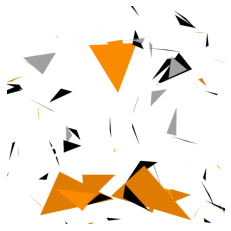

In [6]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

In [1]:
for run in range(1):
    print(f"Run {run + 4}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 4
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [106 106 106]
 [186 186 186]
 [123  68   0]
 [ 34  29  22]
 [224 224 224]
 [146 146 146]
 [ 68  68  68]]
Generation 1, Best Fitness: 4995.295486755514
Generation 2, Best Fitness: 4785.185158382066
Generation 3, Best Fitness: 4767.0886293418125
Generation 4, Best Fitness: 4694.005219426156
Generation 5, Best Fitness: 4626.050907631692
Generation 6, Best Fitness: 4614.082574033542
Generation 7, Best Fitness: 4571.839126653518
Generation 8, Best Fitness: 4548.874915844576
Generation 9, Best Fitness: 4523.588840732544
Generation 10, Best Fitness: 4471.160811243541
Generation 11, Best Fitness: 4471.160811243541
Generation 12, Best Fitness: 4385.744406597357
Generation 13, Best Fitness: 4380.461162937071
Generation 14, Best Fitness: 4380.461162937071
Generation 15, Best Fitness: 4380.461162937071
Generation 16, Best Fitness: 4370.794550193363
Generation 17, Best Fitness: 4358.431828077617
Generation 18, Best Fitness: 4334

Generation 169, Best Fitness: 3457.6930170273936
Generation 170, Best Fitness: 3457.4082778867755
Generation 171, Best Fitness: 3453.1781014016638
Generation 172, Best Fitness: 3453.1781014016638
Generation 173, Best Fitness: 3451.554577288327
Generation 174, Best Fitness: 3447.545068595913
Generation 175, Best Fitness: 3447.32824082651
Generation 176, Best Fitness: 3445.755940283641
Generation 177, Best Fitness: 3442.1198410282
Generation 178, Best Fitness: 3440.11264350457
Generation 179, Best Fitness: 3433.2523938679487
Generation 180, Best Fitness: 3432.940867536171
Generation 181, Best Fitness: 3432.940867536171
Generation 182, Best Fitness: 3429.4654102352456
Generation 183, Best Fitness: 3429.4654102352456
Generation 184, Best Fitness: 3428.1540222107874
Generation 185, Best Fitness: 3427.4664112139744
Generation 186, Best Fitness: 3389.454085837423
Generation 187, Best Fitness: 3374.028008182505
Generation 188, Best Fitness: 3374.028008182505
Generation 189, Best Fitness: 3373.

Generation 339, Best Fitness: 2637.7202277724605
Generation 340, Best Fitness: 2637.7202277724605
Generation 341, Best Fitness: 2636.3021450509045
Generation 342, Best Fitness: 2635.6993379367077
Generation 343, Best Fitness: 2635.496158221446
Generation 344, Best Fitness: 2634.800182177009
Generation 345, Best Fitness: 2634.3908214234275
Generation 346, Best Fitness: 2633.414133781468
Generation 347, Best Fitness: 2633.4033113064925
Generation 348, Best Fitness: 2631.8054639353572
Generation 349, Best Fitness: 2631.8054639353572
Generation 350, Best Fitness: 2630.7789720917262
Generation 351, Best Fitness: 2630.7789720917262
Generation 352, Best Fitness: 2630.5940393758974
Generation 353, Best Fitness: 2630.4915890380644
Generation 354, Best Fitness: 2629.5573772024827
Generation 355, Best Fitness: 2628.552643566417
Generation 356, Best Fitness: 2628.388860119446
Generation 357, Best Fitness: 2626.673752105503
Generation 358, Best Fitness: 2624.131475364754
Generation 359, Best Fitnes

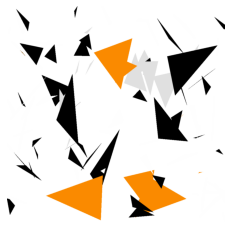

In [2]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5

In [4]:
for run in range(1):
    print(f"Run {run + 5}")
    
    # Load target image
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    # Extract palette from target image
    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    # Initialize and evolve population
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    # Append fitness history for this run to the file
    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 5
Extracted palette: [[  0   0   0]
 [254 254 254]
 [250 138   0]
 [117 117 117]
 [ 73  73  73]
 [212 212 212]
 [119  66   0]
 [164 164 164]
 [ 36  31  24]
 [223 123   0]]
Generation 1, Best Fitness: 4450.490085372621
Generation 2, Best Fitness: 4430.349986174907
Generation 3, Best Fitness: 4410.75004959474
Generation 4, Best Fitness: 4351.315778014738
Generation 5, Best Fitness: 4291.145884259821
Generation 6, Best Fitness: 4237.412771963572
Generation 7, Best Fitness: 4210.235622860079
Generation 8, Best Fitness: 4203.655789904782
Generation 9, Best Fitness: 4173.997963583595
Generation 10, Best Fitness: 4147.888257897023
Generation 11, Best Fitness: 4109.603630522049
Generation 12, Best Fitness: 4093.2647116940775
Generation 13, Best Fitness: 4032.01190474433
Generation 14, Best Fitness: 4025.880028018719
Generation 15, Best Fitness: 4016.1193956355432
Generation 16, Best Fitness: 3987.474890203072
Generation 17, Best Fitness: 3987.474890203072
Generation 18, Best Fitness: 3969.

Generation 169, Best Fitness: 2881.9489933029695
Generation 170, Best Fitness: 2880.743480423066
Generation 171, Best Fitness: 2880.743480423066
Generation 172, Best Fitness: 2877.549999565603
Generation 173, Best Fitness: 2876.82741922417
Generation 174, Best Fitness: 2876.1331679878804
Generation 175, Best Fitness: 2874.087159429929
Generation 176, Best Fitness: 2873.016881259141
Generation 177, Best Fitness: 2872.9550988485707
Generation 178, Best Fitness: 2872.5572231027877
Generation 179, Best Fitness: 2857.734067403753
Generation 180, Best Fitness: 2855.140451886737
Generation 181, Best Fitness: 2851.7422744701175
Generation 182, Best Fitness: 2850.2066591740327
Generation 183, Best Fitness: 2849.971754245996
Generation 184, Best Fitness: 2849.089503683589
Generation 185, Best Fitness: 2848.6653015052507
Generation 186, Best Fitness: 2848.586316052227
Generation 187, Best Fitness: 2847.9901685223563
Generation 188, Best Fitness: 2847.3617613503206
Generation 189, Best Fitness: 28

Generation 338, Best Fitness: 2373.933865970154
Generation 339, Best Fitness: 2373.7310294134
Generation 340, Best Fitness: 2373.7310294134
Generation 341, Best Fitness: 2373.7310294134
Generation 342, Best Fitness: 2348.659617739446
Generation 343, Best Fitness: 2348.659617739446
Generation 344, Best Fitness: 2348.4629015592304
Generation 345, Best Fitness: 2343.4651693592546
Generation 346, Best Fitness: 2343.4651693592546
Generation 347, Best Fitness: 2343.4651693592546
Generation 348, Best Fitness: 2343.4651693592546
Generation 349, Best Fitness: 2340.6381608441748
Generation 350, Best Fitness: 2340.6381608441748
Generation 351, Best Fitness: 2340.1093991520993
Generation 352, Best Fitness: 2339.9743588338742
Generation 353, Best Fitness: 2339.3971445652405
Generation 354, Best Fitness: 2339.070755663454
Generation 355, Best Fitness: 2338.250414305534
Generation 356, Best Fitness: 2337.2911671419974
Generation 357, Best Fitness: 2337.2911671419974
Generation 358, Best Fitness: 2337

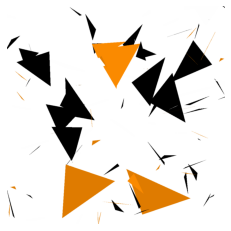

In [5]:
import matplotlib.pyplot as plt

best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

## Plotting mean fitness per generation 

In order to comprate the fitness values using the SSIM and the euclidean distance, we need to normalize the data.

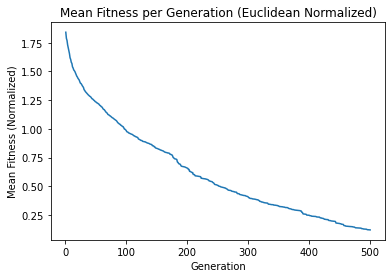

In [10]:
fitness_file = "fitness_values_euclidean.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

min_value = np.min(fitness_values)
max_value = np.max(fitness_values)
normalized_fitness_values = 2 * (fitness_values - min_value) / (max_value - min_value)

mean_fitness_per_generation = np.mean(normalized_fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness (Normalized)')
plt.title('Mean Fitness per Generation (Euclidean Normalized)')
plt.show()
